# Project 4 - West Nile Virus Classification

## Part 3 - Featured Engineering & Modelling

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import joblib

from sklearn.neighbors import KernelDensity

from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, plot_roc_curve, roc_auc_score, f1_score, accuracy_score, auc, precision_recall_curve

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

from imblearn.over_sampling import SMOTE

# ref: https://machinelearningmastery.com/types-of-classification-in-machine-learning/ 

pd.set_option('display.max_rows', 200)

In [2]:
merged_df = pd.read_csv('../assets/clean_data/mergeddf.csv')
merged_df_test = pd.read_csv('../assets/clean_data/mergeddf_test.csv')

### Correlation Heatmap

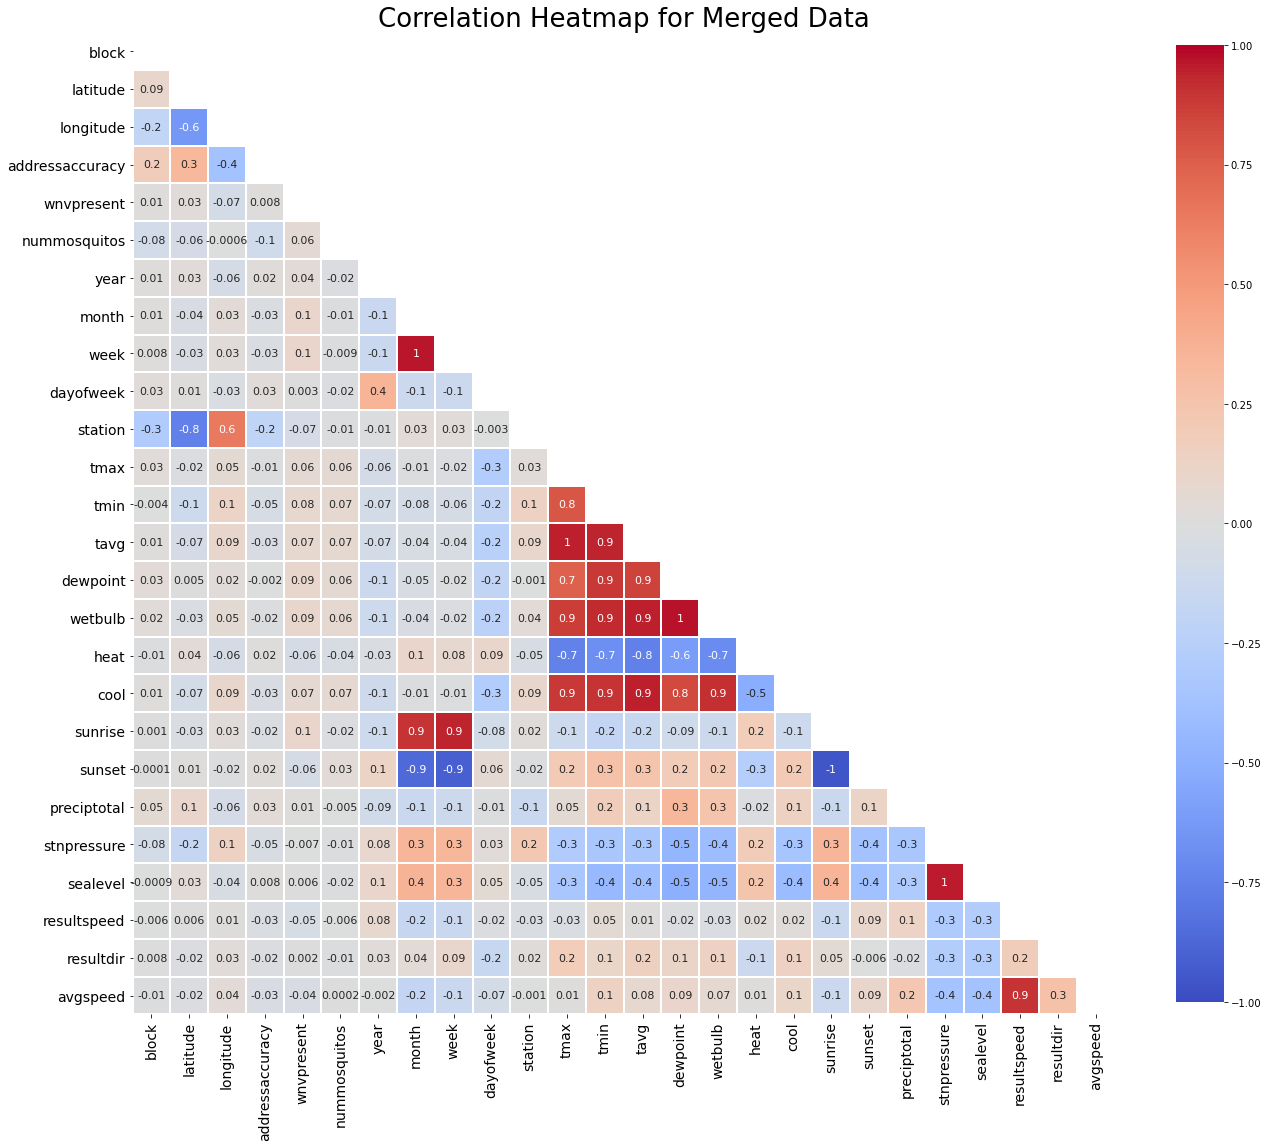

In [3]:
# Look at the heatmap to understand correlation within the fetaures 
def plot_heatmap(dataset, size_x=8, size_y=8, title="", title_font_size=12):
    plt.figure(figsize=(size_x,size_y))

    mask = np.zeros_like(merged_df.corr(), dtype=bool)
    mask[np.triu_indices_from(mask)] = True

    hm = sns.heatmap(merged_df.corr(), mask=mask, cmap='coolwarm',vmin=-1, vmax=1,
                     square=True, linewidth=1,annot=True,annot_kws={'size':'11'},
                     cbar_kws={"shrink": 0.8}, fmt='.1g',center=0)

    hm.set_xticklabels(hm.xaxis.get_ticklabels(), fontsize=14)
    hm.set_yticklabels(hm.yaxis.get_ticklabels(), fontsize=14)

    hm.set_title(title, fontsize=title_font_size);
    
    return hm

plot_heatmap(merged_df, size_x=22, size_y=22, title='Correlation Heatmap for Merged Data', title_font_size=26);

---

# Feature Engineering

### Relative Humidity

Based on our EDA, high humidity is a strong factor in the spread of the West Nile virus, boosting the breed of mosquitoes population in the area. As such, we will look into the percentage of the amount of moisture given the weather.

We use the concept of relative humidity which refers to the moisture content (i.e., water vapour) of the atmosphere, expressed as a percentage of the amount of moisture that can be retained by the atmosphere at a given temperature and pressure without condensation.

In [4]:
# To calculate Relative Humidity, we need to change our features from Fahrenheit to Celcius
def celsius(x):
    c = 5.0 / 9.0 * (x - 32.0)
    return float(c)

In [5]:
# Changing farenheit metrics to degree celsius metrics for temperature
df_list = [merged_df, merged_df_test]

for df in df_list:
    df['tavg'] = df['tavg'].apply(celsius)
    df['tmin'] = df['tmin'].apply(celsius)
    df['tmax'] = df['tmax'].apply(celsius)
    df['dewpoint'] = df['dewpoint'].apply(celsius)

In [6]:
# Create relative humidity features based on calculations
def r_humid(row):
    row['r_humid'] = round(100*(math.exp((17.625*row['dewpoint'])/(243.04+row['dewpoint'])) \
                          / math.exp((17.625*row['tavg'])/(243.04+row['tavg']))))
    return row

In [7]:
# Apply train dataset
merged_df = merged_df.apply(r_humid, axis=1)

In [8]:
# Apply test dataset
merged_df_test = merged_df_test.apply(r_humid, axis=1)

In [9]:
# Save dataset (in case require to reroll)
merged_df1 = merged_df.copy()
merged_df_test1 = merged_df_test.copy()

### Polynomial Features

Using polynomial features to generate new features from existing features.

In [10]:
# Define features based on only numerica dtypes
X = merged_df1[[col for col in merged_df.columns if 'wnvpresent' not in col]]._get_numeric_data()
y = merged_df1['wnvpresent']

In [11]:
poly = PolynomialFeatures(include_bias=False, degree=2)
X_poly = poly.fit_transform(X)
X_poly.shape

(8610, 377)

In [12]:
# Adds appropriate feature names to all polynomial features
X_poly = pd.DataFrame(X_poly,columns=poly.get_feature_names(X.columns))

# Generates list of poly feature correlations
X_poly_corrs = X_poly.corrwith(y)

# Shows features most highly correlated (positively) with target
X_poly_corrs.sort_values(ascending=False).head(10)

wetbulb sunrise     0.143053
week wetbulb        0.139108
month wetbulb       0.136368
week dewpoint       0.132268
month dewpoint      0.129767
dewpoint sunrise    0.125266
week tmin           0.124803
week tavg           0.123299
month tmin          0.122222
sunrise sunset      0.120361
dtype: float64

### Generate new features

In [13]:
# Choosing the top 5 features 
data_set = [merged_df1, merged_df_test1]

for df in data_set:
    df['wetbulb_sunrise'] = df['wetbulb'] * df['sunrise']
    df['week_wetbulb'] = df['week'] * df['wetbulb']
    df['month_wetbulb'] = df['month'] * df['wetbulb']
    df['week_dewpoint'] = df['week'] * df['dewpoint']
    df['month_dewPoint'] = df['month'] * df['dewpoint']

In [14]:
merged_df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8610 entries, 0 to 8609
Data columns (total 39 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   date                    8610 non-null   object 
 1   address                 8610 non-null   object 
 2   species                 8610 non-null   object 
 3   block                   8610 non-null   int64  
 4   street                  8610 non-null   object 
 5   trap                    8610 non-null   object 
 6   addressnumberandstreet  8610 non-null   object 
 7   latitude                8610 non-null   float64
 8   longitude               8610 non-null   float64
 9   addressaccuracy         8610 non-null   int64  
 10  wnvpresent              8610 non-null   int64  
 11  nummosquitos            8610 non-null   int64  
 12  year                    8610 non-null   int64  
 13  month                   8610 non-null   int64  
 14  week                    8610 non-null   

---

# Data Preprocessing

Due to the difference in the dataset, there is a possibility of a difference in features and inputs. We will check both train and test datasets to ensure both have similar features for modelling. Depending on our domain knowledge, those new features created will be filled with 0 or not required will be dropped.

### One-Hot Encoding for Species

In [15]:
# No. of mosquitoes unique values
print (len(merged_df1['species'].unique()))
print (len(merged_df_test1['species'].unique()))

7
8


In [16]:
# Different species of mosquitoes in train dataset
merged_df1['species'].value_counts()

CULEX PIPIENS/RESTUANS    3899
CULEX RESTUANS            2409
CULEX PIPIENS             1996
CULEX TERRITANS            216
CULEX SALINARIUS            83
CULEX TARSALIS               6
CULEX ERRATICUS              1
Name: species, dtype: int64

In [17]:
# Different species of mosquitoes in test dataset
merged_df_test1['species'].value_counts()

CULEX PIPIENS/RESTUANS    15359
CULEX RESTUANS            14670
CULEX PIPIENS             14521
CULEX SALINARIUS          14355
CULEX TERRITANS           14351
CULEX TARSALIS            14347
UNSPECIFIED CULEX         14345
CULEX ERRATICUS           14345
Name: species, dtype: int64

In [18]:
# Check missing in train dataset (test dataset have more values)
value_check = []

# Save additional features in a list
for i in merged_df_test1['species'].unique():
    if i not in merged_df1['species'].unique():
        value_check.append(i)
        
print (value_check)

['UNSPECIFIED CULEX']


In [19]:
# Create get_dummies for 'species'
species_dummies = pd.get_dummies(merged_df1['species'])

# Change column name to str lower and replace / and whitespace with _
species_dummies.columns = species_dummies.columns.str.lower().str.replace('/', '_').str.replace(' ', '_')

# merge species_dummies with merge_df
merged_df1 = pd.concat([merged_df1, species_dummies], axis=1)

In [20]:
# Create get_dummies for 'species'
species_dummies2 = pd.get_dummies(merged_df_test1['species'])

# Change column name to str lower and replace / and whitespace with _
species_dummies2.columns = species_dummies2.columns.str.lower().str.replace('/', '_').str.replace(' ', '_')

# merge species_dummies with merge_df
merged_df_test1 = pd.concat([merged_df_test1, species_dummies2], axis=1)

In [21]:
print (merged_df1.shape)
print (merged_df_test1.shape)

(8610, 46)
(116293, 46)


In [22]:
# Drop feature
merged_df_test1.drop('unspecified_culex', axis=1, inplace=True)

### One-Hot Encoding for Trap

In [23]:
# Check missing in train dataset (test dataset have more values)
value_check2 = []

# Save additional features in a list
for i in merged_df_test1['trap'].unique():
    if i not in merged_df1['trap'].unique():
        value_check2.append(i)
        
print (value_check2)

['T090A', 'T090B', 'T090C', 'T200A', 'T128A', 'T200B', 'T218A', 'T218C', 'T218B', 'T002A', 'T002B', 'T234', 'T065A']


In [24]:
# lower string for 'features'
value_check2 = [each_features.lower() for each_features in value_check2]

# Impute values for missing trap as 0
merged_df1[value_check2] = 0

In [25]:
print (len(merged_df1.columns))
print (len(merged_df_test1.columns))

59
45


In [26]:
# Create get_dummies for 'trap'
trap_dummies = pd.get_dummies(merged_df1['trap'])

# Change column name to str lower and replace / and whitespace with _
trap_dummies.columns = trap_dummies.columns.str.lower().str.replace('/', '_').str.replace(' ', '_')

# merge species_dummies with merge_df
merged_df1 = pd.concat([merged_df1, trap_dummies], axis=1)

In [27]:
# Create get_dummies for 'trap'
trap_dummies = pd.get_dummies(merged_df_test1['trap'])

# Change column name to str lower and replace / and whitespace with _
trap_dummies.columns = trap_dummies.columns.str.lower().str.replace('/', '_').str.replace(' ', '_')

# merge species_dummies with merge_df
merged_df_test1 = pd.concat([merged_df_test1, trap_dummies], axis=1)

In [28]:
print (merged_df1.shape)
print (merged_df_test1.shape)

(8610, 195)
(116293, 194)


### One-Hot Encoding for CodeSum

In [29]:
# One hot encoding for codesum
# Split the codesum column into multiple columns by comparing to all valid codes

valid_codes = ['+FC','FC', 'TS', 'GR', 'RA', 'DZ', 'SN', 'SG', 'GS', 'PL',
         'IC', 'FG+', 'FG', 'BR', 'UP', 'HZ', 'FU', 'VA', 'DU', 'DS',
         'PO', 'SA', 'SS', 'PY', 'SQ', 'DR', 'SH', 'FZ', 'MI', 'PR',
         'BC', 'BL', 'VC']

def conver_codesum_to_col(dataset, valid_code_values):
    for col in valid_code_values:
        dataset[col] = dataset['codesum'].apply(lambda x: 1 if col in x else 0)
        if dataset[col].sum() == 0:
            dataset.drop(columns=[col], inplace=True)
    dataset.drop(columns='codesum', inplace=True)
    dataset.columns = dataset.columns.str.lower().str.replace('/', '_').str.replace(' ', '_')

In [30]:
conver_codesum_to_col(merged_df1, valid_codes)
conver_codesum_to_col(merged_df_test1, valid_codes)

In [31]:
print (merged_df1.shape)
print (merged_df_test1.shape)

(8610, 201)
(116293, 202)


In [32]:
# Check missing in train dataset (test dataset have more values)
value_check3 = []

# Save additional features in a list
for i in merged_df_test1.columns:
    if i not in merged_df1.columns:
        value_check3.append(i)
        
print (value_check3)

['id', 'fg+', 'bc']


In [33]:
# Drop feature
merged_df_test1.drop(['fg+', 'bc' ], axis=1, inplace=True)

In [34]:
print (merged_df1.shape)
print (merged_df_test1.shape)

(8610, 201)
(116293, 200)


### Handling multicollinearity

Multicollinearity is the occurrence of high intercorrelations among two or more independent variables in the model and can lead to skewed or misleading results. Hence, we are dropping features that are collinear to each other.

### Numerical values

Feature that are multicollinearity:
- date: 'week'
- temperature: 'tmin', 'tmax', 'dewpoint', 'wetbulb'
- pressure: 'sealevel'
- speed: 'resultspeed'

In [35]:
# Columns drop list to handle multicollinearity
col_drop_list = ['week', 'tmin', 'tmax', 'dewpoint', 'wetbulb', 'sealevel', 'resultspeed']

for cols in col_drop_list:
    merged_df1.drop(cols, axis=1, inplace=True)
    merged_df_test1.drop(cols, axis=1, inplace=True)

In [36]:
print (merged_df1.shape)
print (merged_df_test1.shape)

(8610, 194)
(116293, 193)


### Non Numerical Data

Drop features that have the same meaning:
- 'date', 'address', 'block'. 'street', 'traps', 'addressnumberandstreet', 'addressaccuracy', 'codesum'

In [37]:
# Columns drop list for merged_df dataset
col_drop_list2 = ['date', 'address', 'block', 'street', 'trap', 'addressnumberandstreet', 'addressaccuracy', 'species', 'nummosquitos']

# columns drop list for merged_df_test dataset - dataset does not include 'nummosquitos'
col_drop_list2_test= ['date', 'address', 'block', 'street', 'trap', 'addressnumberandstreet', 'addressaccuracy', 'species']


for cols2 in col_drop_list2:
    merged_df1.drop(cols2, axis=1, inplace=True)

for cols3 in col_drop_list2_test:
    merged_df_test1.drop(cols3, axis=1, inplace=True)

In [38]:
print (merged_df1.shape)
print (merged_df_test1.shape)

(8610, 185)
(116293, 185)


In [39]:
merged_df2 = merged_df1.copy()
merged_df_test2= merged_df_test1.copy()

# Feature Selection

### Top 40 features

In [40]:
columns = abs(merged_df2.corr()['wnvpresent']).sort_values(ascending=False).head(41)
columns

wnvpresent          1.000000
wetbulb_sunrise     0.143053
week_wetbulb        0.139108
month_wetbulb       0.136368
week_dewpoint       0.132268
month_dewpoint      0.129767
month               0.096551
sunrise             0.096179
culex_pipiens       0.095826
culex_restuans      0.092170
longitude           0.074075
tavg                0.071167
t900                0.069653
cool                0.067013
station             0.065179
fg                  0.063376
sunset              0.058570
heat                0.055015
r_humid             0.049748
br                  0.042748
year                0.042496
culex_territans     0.037979
vc                  0.037541
t003                0.036029
ts                  0.035761
avgspeed            0.035600
t225                0.033060
t143                0.031974
t086                0.030978
latitude            0.030907
t002                0.027869
t223                0.027505
t006                0.026788
t046                0.026433
t115          

In [41]:
merged_df2 = merged_df2[columns.index]

In [42]:
#merged_df2.info()

In [43]:
merged_df2.to_csv('../assets/clean_data/mergeddf_model.csv', index=False)
merged_df_test2.to_csv('../assets/clean_data/mergeddf_test_model.csv', index=False)

---

# Data Modelling

### Train Test Split

In [44]:
# Define X and y features
X = merged_df2.drop('wnvpresent', axis=1)
y = merged_df2['wnvpresent']

In [45]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

### Baseline Model

Classification models deployed:
- Logistic Regression
- K Nearest Neighbors
- Random Forest
- AdaBoost
- GradientBoosting

When running the model with an imbalance dataset, our models immediately highlights the issue of using accuracy for our model. The dataset we are using is biased towards samples where WNV is absent.

From the results of the baseline model. Generally, the models have high accuracy and can classify the training data. However, due to the imbalance in the dataset, all models are unable to predict the relevant positive data. It may be the reason why the high accuracy based on the majority class.

In [46]:
# Baseline
y = merged_df2['wnvpresent']
y.value_counts(normalize=True)

0    0.946922
1    0.053078
Name: wnvpresent, dtype: float64

In [47]:
# Create dataframe to store result of gridsearch for baseline model
results = pd.DataFrame(columns=['model','train_score','test_score', 'precision', 
                                'recall', 'specificity', 'accuracy', 'f1', 'roc_auc'])

In [48]:
# List of models
models = ['logreg', 'knn', 'rf', 'ada', 'gb']

In [49]:
# Pipelines for different based model
list_pipes = [
    [('ss',StandardScaler()),('logreg',LogisticRegression(max_iter=5000))], 
    [('ss',StandardScaler()),('knn',KNeighborsClassifier())],
    [('ss',StandardScaler()),('rf',RandomForestClassifier())],
    [('ss',StandardScaler()),('ada',AdaBoostClassifier())],
    [('ss',StandardScaler()),('gb',GradientBoostingClassifier())]
]

In [50]:
# Run based model with evaluation metrics
for i in range(len(list_pipes)):
    pipe = Pipeline(steps=list_pipes[i])

    pipe.fit(X_train, y_train)

    preds = pipe.predict(X_test)
    
    # Save TN/FP/FN/TP values
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

    # Storing results temporarily in loop
    temp = {}
    
    # Model metrics
    temp['model'] = models[i]
    temp['train_score'] = pipe.score(X_train, y_train)
    temp['test_score'] = pipe.score(X_test, y_test)
    temp['precision'] = tp / (tp + fp)
    temp['recall'] = tp / (tp + fn)
    temp['specificity'] = tn / (tn + fp)
    temp['accuracy'] = accuracy_score(y_test, preds)
    temp['f1'] = f1_score(y_test, preds)
    temp['roc_auc'] = roc_auc_score(y_test, pipe.predict_proba(X_test)[:,1])
    
    results = results.append(temp, ignore_index=True)
    
    # Print summary 
    
    print(f'Model: {models[i]}')
    print('')
    
    print(f'Train Score: {temp["train_score"]}')
    print(f'Test Score: {temp["test_score"]}')
    print('')

    print ("True Negatives: %s" % tn)
    print ("False Positives: %s" % fp)
    print ("False Negatives: %s" % fn)
    print ("True Positives: %s" % tp)
    print('')
    
    # Import ref: https://towardsdatascience.com/what-metrics-should-we-use-on-imbalanced-data-set-precision-recall-roc-e2e79252aeba
    
    print (f'Precision Score: {temp["precision"]}')
    print (f'Recall Score: {temp["recall"]}')
    print (f'Specificity Score: {temp["specificity"]}')
    print (f'Accuracy Score: {temp["accuracy"]}')
    print (f'F1 Score: {temp["f1"]}')
    print ('')
    
    print (f'ROC_AUC Score: {temp["roc_auc"]}')
    print('-------------------------------------------------------------------------------')


Model: logreg

Train Score: 0.946407831425253
Test Score: 0.9469608981804104

True Negatives: 2445
False Positives: 1
False Negatives: 136
True Positives: 1

Precision Score: 0.5
Recall Score: 0.0072992700729927005
Specificity Score: 0.9995911692559281
Accuracy Score: 0.9469608981804104
F1 Score: 0.014388489208633093

ROC_AUC Score: 0.8130375229034741
-------------------------------------------------------------------------------
Model: knn

Train Score: 0.9500580720092915
Test Score: 0.943476577622919

True Negatives: 2432
False Positives: 14
False Negatives: 132
True Positives: 5

Precision Score: 0.2631578947368421
Recall Score: 0.0364963503649635
Specificity Score: 0.9942763695829926
Accuracy Score: 0.943476577622919
F1 Score: 0.0641025641025641

ROC_AUC Score: 0.6987738061843856
-------------------------------------------------------------------------------
Model: rf

Train Score: 0.9880537580886013
Test Score: 0.9376693766937669

True Negatives: 2409
False Positives: 37
False Neg

In [51]:
results[['model', 'train_score', 'test_score','recall', 'accuracy', 'roc_auc']]

,model,train_score,test_score,recall,accuracy,roc_auc
0,logreg,0.946408,0.946961,0.007299,0.946961,0.813038
1,knn,0.950058,0.943477,0.036496,0.943477,0.698774
2,rf,0.988054,0.937669,0.094891,0.937669,0.813825
3,ada,0.946408,0.943864,0.021898,0.943864,0.846123
4,gb,0.949560,0.942702,0.007299,0.942702,0.873268


---

# Best model with hyperparameters

### Handling imbalance dataset

SMOTE (synthetic minority oversampling technique) is one of the most commonly used oversampling methods to solve the imbalance problem. It aims to balance class distribution by randomly increasing minority class examples by replicating them and synthesises new minority instances between existing minority instances.

In [52]:
# SMOTE
smt = SMOTE()
X_train, y_train = smt.fit_resample(X_train, y_train)

In [53]:
X_train.shape

(11414, 40)

In [54]:
X_test.shape

(2583, 40)

In [55]:
y_train.value_counts()

1    5707
0    5707
Name: wnvpresent, dtype: int64

### Functions

In [56]:
results3 = pd.DataFrame()

In [57]:
# Function to calculate metrics
def eva_metrics(gs, preds, model_name):
    
    # Save TN/FP/FN/TP values
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    
    # Storing results temporarily in loop
    temp_mod = {}
    
    # Model metrics
    temp_mod['model'] = model_name
    temp_mod['best_parameters'] = gs.best_params_
    temp_mod['train_score'] = gs.score(X_train, y_train)
    temp_mod['test_score'] = gs.score(X_test, y_test)
    temp_mod['precision'] = tp / (tp + fp)
    temp_mod['recall'] = tp / (tp + fn)
    temp_mod['specificity'] = tn / (tn + fp)
    temp_mod['accuracy'] = accuracy_score(y_test, preds)
    temp_mod['f1'] = f1_score(y_test, preds)
    temp_mod['roc_auc'] = roc_auc_score(y_test, gs.predict_proba(X_test)[:,1])
    
    global results3
    results3 = results3.append(temp_mod, ignore_index=True)

    # Print summary 
    
    print(f'Model: {temp_mod["model"]}')
    print('')
    
    print(f'Best parameters are: {temp_mod["best_parameters"]}')
    print('')
    
    print(f'Train Score: {temp_mod["train_score"]}')
    print(f'Test Score: {temp_mod["test_score"]}')
    print('')

    print ("True Negatives: %s" % tn)
    print ("False Positives: %s" % fp)
    print ("False Negatives: %s" % fn)
    print ("True Positives: %s" % tp)
    print('')
    
    # Import ref: https://towardsdatascience.com/what-metrics-should-we-use-on-imbalanced-data-set-precision-recall-roc-e2e79252aeba
    
    print (f'Precision Score: {temp_mod["precision"]}')
    print (f'Recall Score: {temp_mod["precision"]}')
    print (f'Specificity Score: {temp_mod["specificity"]}')
    print (f'Accuracy Score: {temp_mod["accuracy"]}')
    print (f'F1 Score: {temp_mod["f1"]}')
    print ('')
    
    print (f'ROC_AUC Score: {temp_mod["roc_auc"]}')
    print('-------------------------------------------------------------------------------')
    print ('')
    
    plt.figure(figsize=(8,8))
    plot_roc_curve(gs, X_test, y_test)
    plt.plot([0, 1], [0, 1], label='baseline', linestyle='--')
    plt.title(model_name)
    plt.legend(loc="lower right")
    print ('')
    
    plot_confusion_matrix(pipe, X_test, y_test, cmap='BuGn', values_format='d', display_labels=['0', '1']);
    plt.title(f'Confusion Matrix for {model_name}');

---

### Logistic Regression

In [58]:
# Create pipeline for logistic regression classification model
pipe_logreg = Pipeline([
    ('ss', StandardScaler()),
    ('logreg', LogisticRegression())
])

# Include different hyperparameters
pipe_params_logreg = [{"logreg__n_jobs": [3],
                       "logreg__penalty":['l2'],
                       "logreg__C": np.arange(1, 5, 0.1),
                       "logreg__max_iter": [5000]}]

In [59]:
# Instantiate GridSearchCV
gs = GridSearchCV(pipe_logreg, pipe_params_logreg, cv=5, verbose=2) 

#Fit GridSearchCV
gs.fit(X_train, y_train)

# Find predictors
preds = gs.predict(X_test)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV] END logreg__C=1.0, logreg__max_iter=5000, logreg__n_jobs=3, logreg__penalty=l2; total time=   3.1s
[CV] END logreg__C=1.0, logreg__max_iter=5000, logreg__n_jobs=3, logreg__penalty=l2; total time=   2.6s
[CV] END logreg__C=1.0, logreg__max_iter=5000, logreg__n_jobs=3, logreg__penalty=l2; total time=   2.7s
[CV] END logreg__C=1.0, logreg__max_iter=5000, logreg__n_jobs=3, logreg__penalty=l2; total time=   1.5s
[CV] END logreg__C=1.0, logreg__max_iter=5000, logreg__n_jobs=3, logreg__penalty=l2; total time=   1.4s
[CV] END logreg__C=1.1, logreg__max_iter=5000, logreg__n_jobs=3, logreg__penalty=l2; total time=   1.4s
[CV] END logreg__C=1.1, logreg__max_iter=5000, logreg__n_jobs=3, logreg__penalty=l2; total time=   1.6s
[CV] END logreg__C=1.1, logreg__max_iter=5000, logreg__n_jobs=3, logreg__penalty=l2; total time=   1.6s
[CV] END logreg__C=1.1, logreg__max_iter=5000, logreg__n_jobs=3, logreg__penalty=l2; total time=   1.5s
[C

[CV] END logreg__C=2.4000000000000012, logreg__max_iter=5000, logreg__n_jobs=3, logreg__penalty=l2; total time=   2.2s
[CV] END logreg__C=2.4000000000000012, logreg__max_iter=5000, logreg__n_jobs=3, logreg__penalty=l2; total time=   2.2s
[CV] END logreg__C=2.4000000000000012, logreg__max_iter=5000, logreg__n_jobs=3, logreg__penalty=l2; total time=   2.0s
[CV] END logreg__C=2.4000000000000012, logreg__max_iter=5000, logreg__n_jobs=3, logreg__penalty=l2; total time=   2.4s
[CV] END logreg__C=2.4000000000000012, logreg__max_iter=5000, logreg__n_jobs=3, logreg__penalty=l2; total time=   2.1s
[CV] END logreg__C=2.5000000000000013, logreg__max_iter=5000, logreg__n_jobs=3, logreg__penalty=l2; total time=   2.7s
[CV] END logreg__C=2.5000000000000013, logreg__max_iter=5000, logreg__n_jobs=3, logreg__penalty=l2; total time=   2.2s
[CV] END logreg__C=2.5000000000000013, logreg__max_iter=5000, logreg__n_jobs=3, logreg__penalty=l2; total time=   2.2s
[CV] END logreg__C=2.5000000000000013, logreg__m

[CV] END logreg__C=3.8000000000000025, logreg__max_iter=5000, logreg__n_jobs=3, logreg__penalty=l2; total time=   2.8s
[CV] END logreg__C=3.8000000000000025, logreg__max_iter=5000, logreg__n_jobs=3, logreg__penalty=l2; total time=   2.4s
[CV] END logreg__C=3.8000000000000025, logreg__max_iter=5000, logreg__n_jobs=3, logreg__penalty=l2; total time=   2.7s
[CV] END logreg__C=3.8000000000000025, logreg__max_iter=5000, logreg__n_jobs=3, logreg__penalty=l2; total time=   2.2s
[CV] END logreg__C=3.8000000000000025, logreg__max_iter=5000, logreg__n_jobs=3, logreg__penalty=l2; total time=   2.8s
[CV] END logreg__C=3.9000000000000026, logreg__max_iter=5000, logreg__n_jobs=3, logreg__penalty=l2; total time=   2.4s
[CV] END logreg__C=3.9000000000000026, logreg__max_iter=5000, logreg__n_jobs=3, logreg__penalty=l2; total time=   3.0s
[CV] END logreg__C=3.9000000000000026, logreg__max_iter=5000, logreg__n_jobs=3, logreg__penalty=l2; total time=   2.9s
[CV] END logreg__C=3.9000000000000026, logreg__m

Model: logreg

Best parameters are: {'logreg__C': 2.7000000000000015, 'logreg__max_iter': 5000, 'logreg__n_jobs': 3, 'logreg__penalty': 'l2'}

Train Score: 0.8078675311021553
Test Score: 0.7197057684862563

True Negatives: 1793
False Positives: 653
False Negatives: 71
True Positives: 66

Precision Score: 0.0917941585535466
Recall Score: 0.0917941585535466
Specificity Score: 0.7330335241210139
Accuracy Score: 0.7197057684862563
F1 Score: 0.15420560747663553

ROC_AUC Score: 0.7038737459042322
-------------------------------------------------------------------------------




<Figure size 576x576 with 0 Axes>

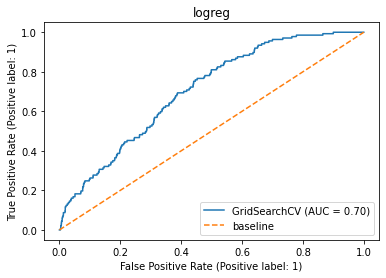

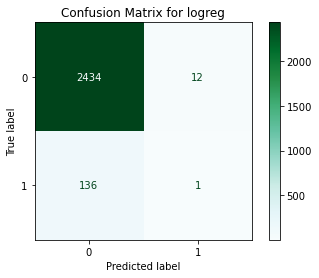

In [60]:
# Evaluation metrics
eva_metrics(gs, preds, 'logreg')

In [61]:
results3

,accuracy,best_parameters,f1,model,precision,recall,roc_auc,specificity,test_score,train_score
0,0.719706,"{'logreg__C': 2.7000000000000015, 'logreg__max...",0.154206,logreg,0.091794,0.481752,0.703874,0.733034,0.719706,0.807868


### K Nearest Neighbors

In [62]:
# Create pipeline for k nearest neighbors classification model
pipe_knn = Pipeline([
    ('ss', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

# Ref: https://medium.datadriveninvestor.com/k-nearest-neighbors-in-python-hyperparameters-tuning-716734bc557f
# Ref: https://medium.com/swlh/the-hyperparameter-cheat-sheet-770f1fed32ff
n_neighbors = list(range(1,10))

# Include different hyperparameters
pipe_params_knn = [{"knn__n_neighbors": n_neighbors}]

In [ ]:
# Instantiate GridSearchCV
gs2 = GridSearchCV(pipe_knn, pipe_params_knn, cv=5, verbose=2) 

#Fit GridSearchCV
gs2.fit(X_train, y_train)

# Find predictors
preds2 = gs2.predict(X_test)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END .................................knn__n_neighbors=1; total time=   0.5s
[CV] END .................................knn__n_neighbors=1; total time=   0.5s
[CV] END .................................knn__n_neighbors=1; total time=   0.6s
[CV] END .................................knn__n_neighbors=1; total time=   0.6s
[CV] END .................................knn__n_neighbors=1; total time=   0.6s
[CV] END .................................knn__n_neighbors=2; total time=   0.6s
[CV] END .................................knn__n_neighbors=2; total time=   0.6s
[CV] END .................................knn__n_neighbors=2; total time=   0.7s
[CV] END .................................knn__n_neighbors=2; total time=   0.8s
[CV] END .................................knn__n_neighbors=2; total time=   0.8s
[CV] END .................................knn__n_neighbors=3; total time=   0.7s
[CV] END .................................knn__n_

In [ ]:
# Evaluation metrics
eva_metrics(gs2, preds2, 'knn')

In [ ]:
results3

### Random Forest 

In [ ]:
# Create pipeline for random forest classification model
pipe_rf = Pipeline([
    ('ss', StandardScaler()),
    ('rf', RandomForestClassifier())
])

# Ref: https://medium.com/swlh/the-hyperparameter-cheat-sheet-770f1fed32ff
n_estimators = np.arange(100, 200, 20)
max_depth = [None, 1, 2, 3, 4, 5]

# Include different hyperparameters
pipe_params_rf = [{"rf__n_estimators": n_estimators,
                   "rf__max_depth": max_depth}]

In [ ]:
# Instantiate GridSearchCV
gs3 = GridSearchCV(pipe_rf, pipe_params_rf, cv=5, verbose=2) 

#Fit GridSearchCV
gs3.fit(X_train, y_train)

# Find predictors
preds3 = gs3.predict(X_test)

In [ ]:
# Evaluation metrics
eva_metrics(gs3, preds3, 'rf')

In [ ]:
results3

### AdaBoost

In [ ]:
# Create pipeline for adaboost classification model
pipe_ada = Pipeline([
    ('ss', StandardScaler()),
    ('ada', AdaBoostClassifier())
])

# Ref: https://medium.com/swlh/the-hyperparameter-cheat-sheet-770f1fed32ff
n_estimators = [100, 200]
learning_rate = [0.001, 0.01, 0.1, 0.2, 0.5]

# Include different hyperparameters
pipe_params_ada = [{"ada__n_estimators": n_estimators,
                   "ada__learning_rate": learning_rate}]

In [ ]:
# Instantiate GridSearchCV
gs4 = GridSearchCV(pipe_ada, pipe_params_ada, cv=5, verbose=2) 

#Fit GridSearchCV
gs4.fit(X_train, y_train)

# Find predictors
preds4 = gs4.predict(X_test)

In [ ]:
# Evaluation metrics
eva_metrics(gs4, preds4, 'ada')

In [ ]:
results3

### Gradient Boosting 

In [ ]:
# Create pipeline for adaboost classification model
pipe_gb = Pipeline([
    ('ss', StandardScaler()),
    ('gb', GradientBoostingClassifier())
])

# Ref: https://medium.com/swlh/the-hyperparameter-cheat-sheet-770f1fed32ff
n_estimators = [100, 200]
learning_rate = [0.001, 0.01, 0.1, 0.2, 0.5]

# Include different hyperparameters
pipe_params_gb = [{"gb__n_estimators": n_estimators,
                   "gb__learning_rate": learning_rate}] 

In [ ]:
# Instantiate GridSearchCV
gs5 = GridSearchCV(pipe_gb, pipe_params_gb, cv=5, verbose=2) 

#Fit GridSearchCV
gs5.fit(X_train, y_train)

# Find predictors
preds5 = gs5.predict(X_test)

In [ ]:
# Evaluation metrics
eva_metrics(gs5, preds5, 'gb')

In [ ]:
results3[['model', 'best_parameters', 'precision', 
          'recall', 'roc_auc', 'accuracy']]

In [ ]:
merged_df3 = merged_df2.copy()
merged_df_test3 = merged_df_test2.copy()

From our results, models tends to perform better after applying SMOTE. After tuning the hyperparameters of each model, the ROC_AUC scores decreases slightly but Recall scores increases. This shows that the model is able to identify positive class in the dataset.

Comparing the results, we have decided to use AdaBoost as our model as it fulfills 2 criterias, ROC_AUC to distingusihed the classes proper with a score of 80% and Recall to find relevant predictions with a score of 60%

 # Best Model Evaluation

Best model: AdaBoostingClassifier
- learning_rate (0.5) 
- n_estimators (200)

Interestingly, featured engineered features are a strong predictors in our model.

In [ ]:
# Define X features
X2 = merged_df_test3.drop('id', axis=1)

In [ ]:
#len(X2.columns)

In [ ]:
columns = columns[1:]

In [ ]:
#len(columns.index)

In [ ]:
X2 = X2[columns.index]

In [ ]:
# Create pipeline for each kneighborsclassifier classification model
pipe_ada = [('ss', StandardScaler()),
            ('ada', AdaBoostClassifier(learning_rate=0.5, n_estimators=200))]

In [ ]:
# Instantiate Pipeline
pipe = Pipeline(pipe_ada)

# Fit model
pipe.fit(X_train, y_train)

# Predictions
preds_final = pipe.predict(X2)
preds_final2 = pipe.predict_proba(X2)

In [ ]:
eva_metrics(pipe, preds_final, 'ada')

In [ ]:
df_coef = pd.DataFrame(pipe.named_steps.ada.feature_importances_, columns=['Feature Importance'])
df_coef['Feature Name'] = X_train.columns
df_coef.sort_values(by='Feature Importance', ascending=False)[['Feature Name', 'Feature Importance']].head(20)

In [ ]:
plot_coef = df_coef[['Feature Name', 'Feature Importance']]

In [ ]:
a = plot_coef.sort_values(by='Feature Importance', ascending=False)['Feature Name'][0:10]
b = plot_coef.sort_values(by='Feature Importance', ascending=False)['Feature Importance'][0:10]

In [ ]:
plt.figure(figsize=(10,8))
plt.bar(a, b, color='darkgoldenrod')
plt.title('AdaBoost Feature Importance')
plt.xlabel('Feature Name')
plt.ylabel('Scores')
plt.xticks(rotation=45);

### For Kaggle Submission

In [ ]:
submission = pd.DataFrame(merged_df_test['id'])
submission.columns = ['Id']

In [ ]:
#submission['Id']

In [ ]:
submission['WnvPresent'] = preds_final

In [ ]:
submission.info()

In [ ]:
submission.head()

In [ ]:
# Export data to csv for Kaggle submission
submission.to_csv('../assets/clean_data/submission.csv', index=False)

### Final Test dataset with predictions

In [ ]:
final_df = merged_df_test.copy()

In [ ]:
# Create new column for predictors
final_df['wnvpresent'] = preds_final

In [ ]:
# Create new column for predictors probability
final_df[['wnvpresentprob1', 'wnvpresentprob2']] = preds_final2

In [ ]:
final_df.head()

In [ ]:
final_df.info()

In [ ]:
final_df.to_csv('../assets/clean_data/final_test.csv', index=False)

---